# **1. Loading Libraries**

In [106]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from tqdm import tqdm, tqdm_notebook
from skimage.io import imread, imsave
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
%matplotlib inline

# **Displaying sample images of 5 chosen classes**
1.   airplane
2.   beach
2.   chaparral
4.   forest
5.   harbor




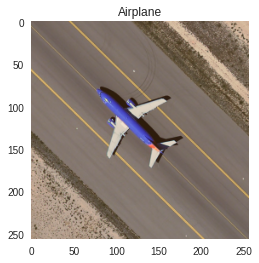

In [100]:
plt.imshow(imread('/content/drive/MyDrive/Colab Notebooks/data/UCMerced_LandUse/Images/airplane/airplane78.tif'))
plt.title("Airplane")
plt.grid(None)
plt.show()

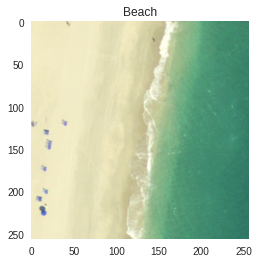

In [102]:
plt.imshow(imread('/content/drive/MyDrive/Colab Notebooks/data/UCMerced_LandUse/Images/beach/beach90.tif'))
plt.title("Beach")
plt.grid(None)
plt.show()

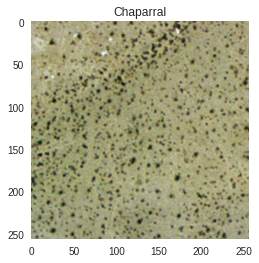

In [103]:
plt.imshow(imread('/content/drive/MyDrive/Colab Notebooks/data/UCMerced_LandUse/Images/chaparral/chaparral04.tif'))
plt.title("Chaparral")
plt.grid(None)
plt.show()

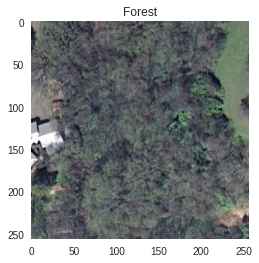

In [104]:
plt.imshow(imread('/content/drive/MyDrive/Colab Notebooks/data/UCMerced_LandUse/Images/forest/forest08.tif'))
plt.title("Forest")
plt.grid(None)
plt.show()

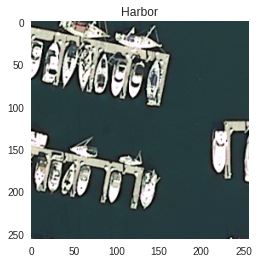

In [105]:
plt.imshow(imread('/content/drive/MyDrive/Colab Notebooks/data/UCMerced_LandUse/Images/harbor/harbor96.tif'))
plt.title("Harbor")
plt.grid(None)
plt.show()

# **3. Train Test Split**
80% Train Data

10% Test Data

10% Validation Data

In [122]:
source_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/data', 'UCMerced_LandUse', 'Images')


# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('/content/drive/MyDrive/Colab Notebooks/data', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in tqdm(filenames[:count]):
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
                  
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()






  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)





  4%|▍         | 3/80 [00:00<00:03, 19.90it/s]




  8%|▊         | 6/80 [00:00<00:03, 21.10it/s]




 10%|█         | 8/80 [00:00<00:03, 20.13it/s]




 14%|█▍        | 11/80 [00:00<00:03, 19.36it/s]




 16%|█▋        | 13/80 [00:00<00:05, 12.83it/s]




 20%|██        | 16/80 [00:00<00:04, 14.92it/s]




 22%|██▎       | 18/80 [00:01<00:03, 16.04it/s]




 25%|██▌       | 20/80 [00:01<00:03, 15.35it/s]




 29%|██▉       | 23/80 [00:01<00:03, 16.93it/s]




 32%|███▎      | 26/80 [00:01<00:02, 19.33it/s]




 36%|███▋      | 29/80 [00:01<00:02, 20.83it/s]




 40%|████      | 32/80 [00:01<00:02, 22.13it/s]




 44%|████▍     | 35/80 [00:01<00:02, 21.90it/s]




 49%|████▉     | 39/80 [00:01<

In [123]:
means = []
for root, _, filenames in os.walk(target_dirs['train']):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        image = imread(filepath)
        means.append(np.mean(image, axis=(0, 1)))
channel_means = np.mean(means, axis=0)

# **4. Image Data Generator and features**

In [126]:
def get_bottleneck_features(model, dataset, preproc_func, batch_size=64):
    """
    Get botteleneck features X and labels Y for the input dataset (train/validate/test)
    by predicting on the convolutional portion only of a pretrained model.
    
    Note: Saves features and labels to numpy files for future use when rerunning the code.
        
    Inputs:
        model: Pre-trained deep learning model, excluding fully-connected top model
               e.g. applications.VGG16(include_top=False, weights='imagenet')
        dataset = string label for dataset image directory ['train', 'validate', 'test']
        preproc_func: preprocessing function implied to each input sample
        batch_size: number of image samples per batch
    
    Return:
        Return bottleneck features as numpy.array
    """

    print(f'Generating "{dataset}" bottleneck predictions')
    X_filepath = os.path.join('/content/drive/MyDrive/Colab Notebooks/data', 'bn_' + dataset + '_X.npy')
    y_filepath = os.path.join('/content/drive/MyDrive/Colab Notebooks/data', 'bn_' + dataset + '_y.npy')

    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
        with open(y_filepath, 'rb') as f:
            y = np.load(f)
            Y = to_categorical(y, num_classes=len(np.unique(y)))
    # Else, get the bottleneck features and labels
    except:
        image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preproc_func)
        image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=batch_size,
                                                             shuffle=False
                                                             )
        image_count = 0
        X_batches, Y_batches = [], []
        for X, Y in image_generator:
            X_batches.append(model.predict_on_batch(X))
            Y_batches.append(Y)
            image_count += X.shape[0]
            # Must interrupt image_generator
            if image_count >= image_generator.n:
                break

        X = np.concatenate(X_batches)
        with open(X_filepath, 'wb') as f:
            np.save(f, X) 
        Y = np.concatenate(Y_batches)
        y = np.nonzero(Y)[1]
        with open(y_filepath, 'wb') as f:
            np.save(f, y)
    
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y

In [129]:
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')

In [130]:
num_classes = len(class_names)
X, Y = dict(), dict()
preprocess = lambda x: x - channel_means
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset, preprocess)

Generating "train" bottleneck predictions
   Features of shape (400, 8, 8, 512) extracted for model "vgg16"
Generating "validate" bottleneck predictions
   Features of shape (50, 8, 8, 512) extracted for model "vgg16"
Generating "test" bottleneck predictions
   Features of shape (50, 8, 8, 512) extracted for model "vgg16"


# **5. MODEL, ADAM OPTIMIZER AND TRAINING**

In [131]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [132]:
# Build, compile, and fit the model
model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=10,
                              verbose=2, validation_data=(X['validate'], Y['validate']))

Epoch 1/10
7/7 - 0s - loss: 53.1234 - accuracy: 0.3425 - val_loss: 2.8377 - val_accuracy: 0.9200
Epoch 2/10
7/7 - 0s - loss: 6.8286 - accuracy: 0.8350 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/10
7/7 - 0s - loss: 2.2037 - accuracy: 0.9100 - val_loss: 0.3154 - val_accuracy: 0.9800
Epoch 4/10
7/7 - 0s - loss: 1.4911 - accuracy: 0.9575 - val_loss: 0.0639 - val_accuracy: 0.9800
Epoch 5/10
7/7 - 0s - loss: 0.9603 - accuracy: 0.9625 - val_loss: 0.1869 - val_accuracy: 0.9800
Epoch 6/10
7/7 - 0s - loss: 0.6775 - accuracy: 0.9725 - val_loss: 0.1122 - val_accuracy: 0.9800
Epoch 7/10
7/7 - 0s - loss: 0.3068 - accuracy: 0.9775 - val_loss: 0.0230 - val_accuracy: 0.9800


/usr/lib/python3.6/inspect.py:732: ResourceWarning: unclosed file <_io.BufferedWriter name='/content/drive/MyDrive/Colab Notebooks/data/flow/train/beach/beach54.png'>
  for modname, module in list(sys.modules.items()):
/usr/lib/python3.6/inspect.py:732: ResourceWarning: unclosed file <_io.BufferedWriter name='/content/drive/MyDrive/Colab Notebooks/data/flow/test/beach/beach02.png'>
  for modname, module in list(sys.modules.items()):


Epoch 8/10
7/7 - 0s - loss: 0.1324 - accuracy: 0.9900 - val_loss: 2.8372e-07 - val_accuracy: 1.0000
Epoch 9/10
7/7 - 0s - loss: 0.0469 - accuracy: 0.9850 - val_loss: 2.2089e-04 - val_accuracy: 1.0000
Epoch 10/10
7/7 - 0s - loss: 0.2386 - accuracy: 0.9875 - val_loss: 2.3842e-09 - val_accuracy: 1.0000


# **6. PERFORMANCE**

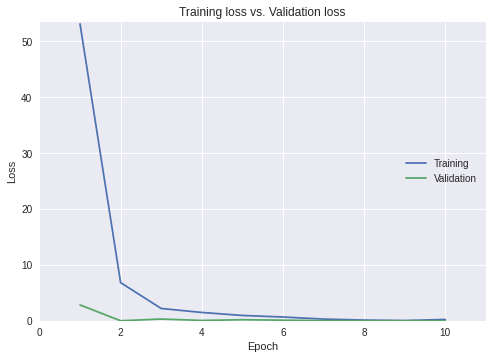

In [133]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

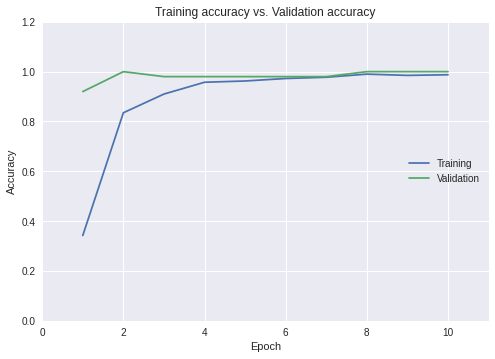

In [134]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [135]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

# Merge training and validation data
X_train = np.concatenate([X['train'], X['validate']])
Y_train = np.concatenate([Y['train'], Y['validate']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=64, epochs=epochs, verbose=0)

Stop training at 10 epochs


In [136]:
y_pred = model.predict_classes(X['test'], verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# **7. ACCURACY**

In [137]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')
cnf = confusion_matrix(y_test, y_pred)

Model predication accuracy: 0.980

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      0.90      0.95        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



# **PLOTTING CONFUSION MATRIX**

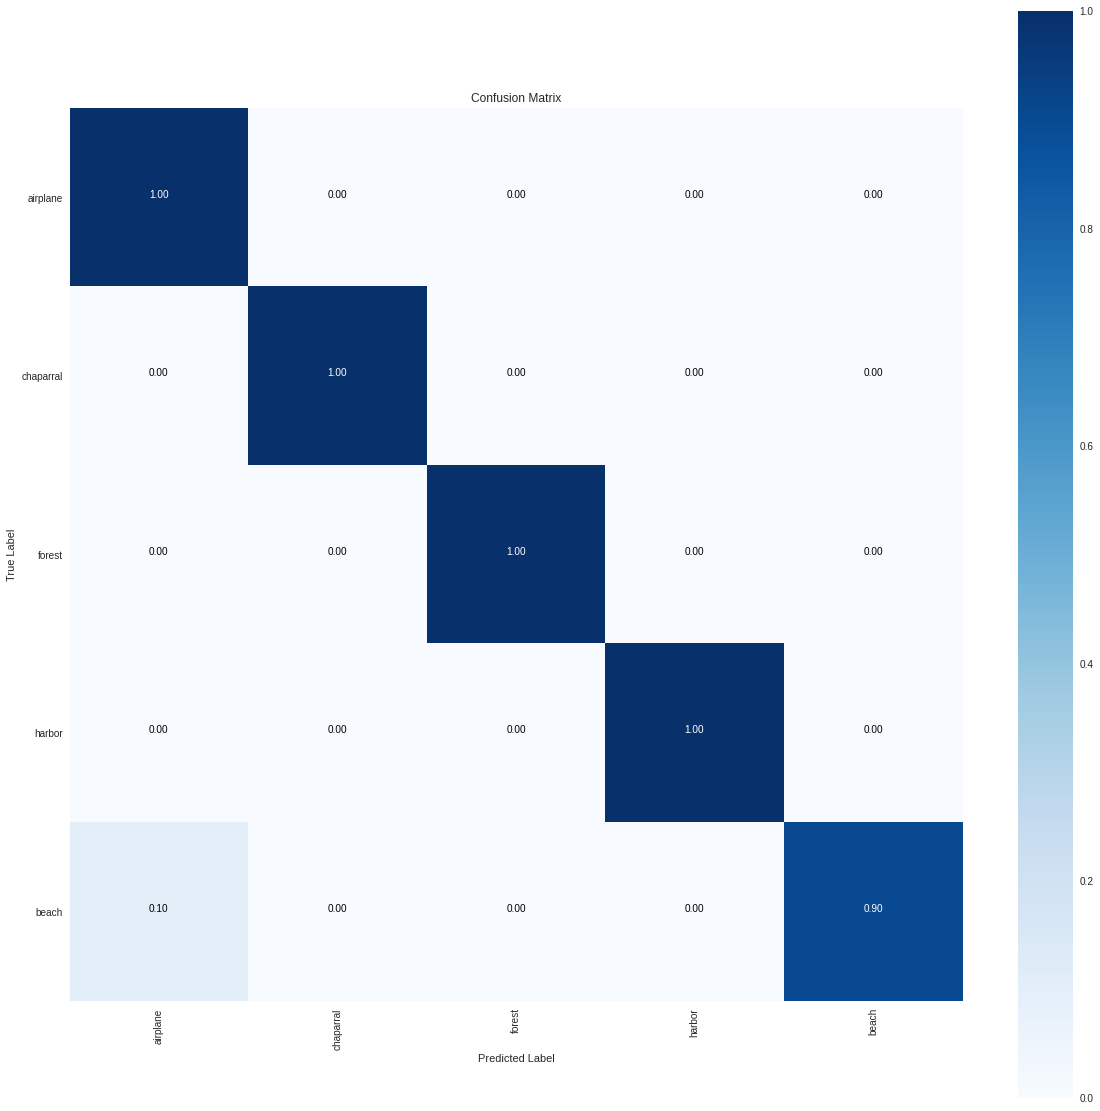

In [138]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);
    pass
plot_confusion_matrix(cnf, classes=class_names)